In [39]:
#pip install cv

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import re
import numpy as np
from PyKomoran import *
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import warnings
warnings.filterwarnings(action='ignore')
import json
from datetime import datetime
import ast

from wordcloud import WordCloud
import imageio
import matplotlib
import cv

font_path="data/28 NanumGothic.ttf" #pre-defined folder my computer

%matplotlib inline
# 그래프에 한글 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 그래프에 마이너스 기호 깨지는 문제 해결
plt.rcParams['axes.unicode_minus'] = False

pd.set_option('mode.chained_assignment',  None)
#df overwrite warning off

komoran = Komoran('STABLE')

## 데이터 수집

### 유튜브 브이로그 웹 크롤링 

"브이로그크롤링.py"를 통해 유튜브 웹페이지에서 브이로그를 크롤링을 함
( 제목, 링크 , 조회수, 영상길이)

기간 - 2021년 8월 22일 ~ 2022년 8월 22일

( 조원당 2개월씩 분할 하여 크롤링 수행 )

"브이로그 디테일 추출.ipynb"

그후, 해당 목록을 유튜브 API와 BS를 활용하여 
업로드일 , 실제조회수, 설명, 좋아요 를 수집함

In [41]:
vlog = pd.read_excel('data/브이로그디테일추출.xlsx')

## 데이터 전처리

### 제목 에 대한 전처리

In [42]:
# 컬럼 언네임 제거
vlog.drop(columns='Unnamed: 0',inplace=True)

In [43]:
#업로드일 datetime으로 변경
vlog['업로드일'] = pd.to_datetime(vlog['업로드일'])

#업로드일 기준 정렬
vlog = vlog.sort_values('업로드일')

#SHORTS 
vlogs = vlog[vlog['영상길이']!='SHORTS']

In [44]:
#조회수 컬럼 드랍
vlogs.drop(columns='조회수',inplace=True)

#실제 조회수 를 조회수로 이름 변경
vlogs.rename(columns = {'실제조회수':'조회수'}, inplace = True)

# 인덱스 리셋
vlogs.reset_index(inplace=True)

# 인덱스 컬럼을 드랍
vlogs.drop(columns='index',inplace=True)

In [45]:
#제목,설명 컬럼 영어 대문자로 변환
vlogs['제목'] = vlogs['제목'].str.upper()
vlogs['설명']=vlogs['설명'].str.upper()

In [46]:
# Basic Cleaning Text Function
def CleanText(readData, Num=True, Eng=False):
# 멘션(@) 제거
    text = re.sub('@[\w_]+', '',readData)

# 대괄호 제거 
    text=re.sub('\[.*\]','',text)
#Remove parentices
    text=re.sub('\(.*\)','',text)

# URL 제거 또는 교체
    text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", ' ', text) # http로 시작되는 url
    text = re.sub(r"[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{2,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)", ' ', text) # http로 시작되지 않는 url

# 해시태그 지움
 #   text = re.sub('[#]+[0-9a-zA-Z_]+', ' ', text)

# &+단어 제거 (ex. &lt, &gt, etc)
    text = re.sub('[&]+[a-z]+', ' ', text)

# 특수문자제거
    text = re.sub('[^0-9a-zA-Zㄱ-ㅎ가-힣]', ' ', text)

# 행제거
    text = text.replace('\n',' ')

    if Num is True:
# 숫자제거
        text = re.sub(r'\d+',' ',text)

    if Eng is True:
        
# 영어제거
        text = re.sub('[a-zA-Z]' , ' ', text)


# 다중공백제거
    text = ' '.join(text.split())
    
    if len(text)<10:
        return np.nan
    else:
        return text

    if len>=512:
        return text
    else:
        return np.nan
    return text


In [47]:
#한글만 남기고 다 전처리
vlogs['제목']=[CleanText(str(i)) for i in vlogs['제목']]

vlogs['설명']=[CleanText(str(i)) for i in vlogs['설명']]

In [48]:
# 결측지 확인
vlogs.isnull().sum()

제목         62
링크          0
영상길이        8
동영상_ID      0
업로드일        0
조회수         0
설명        130
좋아요       216
dtype: int64

In [49]:
#결측지 제거
vlogs.dropna(inplace=True)

In [50]:
# 제목 과 설명을 붙이기 위한 뛰어쓰기 컬럼 생성
vlogs['empty']=' '

In [51]:
#text에 제목, empty , 설명을 컬럼을 추가하여 합침
vlogs['text'] = vlogs['제목'].copy()+vlogs['empty'].copy()+vlogs['설명'].copy()

In [52]:
# 명사추출
nouns =[]
for t in vlogs['text']:
    try:
        nouns.append(komoran.get_nouns(t))

    except:
        nouns.append(['aa','bb'])
    

In [53]:
# 한글자 단어 제외
temp=[]
for i in nouns:
    temp2=[]
    for j in i:
        if len(j)>1:
            temp2.append(j)
    temp.append(' '.join(temp2))
        

In [54]:
#tt = 명사를 추출한후, 한글자인 키워드를 제외한 컬럼
vlogs['tt']=temp

# 그후에 의미없는 단어들 전처리
ttt = []
for i in vlogs['tt']:
    i = i.replace('브이', '')
    i = i.replace('로그', '')
    i = i.replace('VLOG','')
    i = i.replace('브이로그','')
    i = i.replace('영상', '')
    i = i.replace('  ', '')
    i = i.replace('   ','')
    i = i.replace('    ','')
    ttt.append(i)
vlogs['ttt']=ttt

In [55]:
#저장 전 널값 확인
vlogs.isnull().sum()

제목        0
링크        0
영상길이      0
동영상_ID    0
업로드일      0
조회수       0
설명        0
좋아요       0
empty     0
text      0
tt        0
ttt       0
dtype: int64

In [56]:
#토픽모델링 재료 저장
vlogs.to_excel('1.Data/text.xlsx')

## 토픽 모델링

"TopicModeling_v1.ipynb"
제목과 설명을 전처리하고 합친 구문(' ttt ')컬럼에서 명사를 추출하여
키워드 빈도수를 활용하여 토픽모델링을 진행

다섯개의 토픽으로 분류가 가장 명확하게 됨.

결과:

(3.Result/Result_lda_vis.html)

(3.Result/Result_topic_excel.xlsx)


## 카테고리별 월간 업로드 비교

In [4]:
# 토픽 모델링 결과값 엑셀 불러옴
topic = pd.read_excel('3.Result/Result_topic_excel.xlsx')

In [5]:
#언네임드 제거
topic.drop(columns='Unnamed: 0',inplace=True)

In [6]:
topic

,제목,링크,영상길이,동영상_ID,업로드일,조회수,설명,empty,text,tt,...,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,topic1,topic2,topic3,topic4,topic5,좋아요
0,마지막 여름 뒤늦게 올리는 당일 휴가 브이로그,https://www.youtube.com/watch?v=0-KR5xancG8,9:42,0-KR5xancG8,2021-08-22,1000302,당일치기 휴가 브이로그여러분 안녕하세요 아주 오래전에 다녀왔는데 이제야 업로드 하네...,,마지막 여름 뒤늦게 올리는 당일 휴가 브이로그 당일치기 휴가 브이로그여러분 안녕하세...,마지막 여름 당일 휴가 브이 로그 당일치기 휴가 브이 로그 여러분 오래전 업로드 오...,...,4,0.5332,"스타, 일상, 다이어트, 일본, 커플, 사장, 운동, 튜브, 촬영, 데이트","['마지막', '여름', '당일', '휴가', '당일치기', '휴가', '여러분',...",0.038370,0.197099,0.109923,0.533161,0.121447,31363개
1,플레이리스트 최근 브이로그에 사용된 분위기 있는 음악들,https://www.youtube.com/watch?v=hXG5KPiEc_0,30:01,hXG5KPiEc_0,2021-08-23,303694,평소 영상을 올리면 음악 정보를 물어보시는 분들이 꽤 있었는데 저는 일반 음원 사이...,,플레이리스트 최근 브이로그에 사용된 분위기 있는 음악들 평소 영상을 올리면 음악 정...,플레이 리스트 최근 브이 로그 사용 분위기 음악 평소 영상 음악 정보 일반 사이트 ...,...,2,0.8116,"가족, 쇼핑, 방학, 오늘, 친구, 채널, 포장, 일상, , 제품","['플레이', '리스트', '최근', '사용', '분위기', '음악', '평소음악'...",0.103916,0.811623,0.018969,0.042342,0.023150,11722개
2,신화외고 강찬 의 브이로그 일상 공개,https://www.youtube.com/watch?v=Ehcb97Nmpoc,2:30,Ehcb97Nmpoc,2021-08-24,184817,강찬과 마혁에 관한 댓글이 많아 짧게 근황 영상을 올려봅니다 강찬 마혁 엄석두 우리...,,신화외고 강찬 의 브이로그 일상 공개 강찬과 마혁에 관한 댓글이 많아 짧게 근황 영...,신화 브이 로그 일상 공개 근황 영상 우정,...,5,0.4393,"광고, 여름, 일상, 포함, 공부, 직장인, 하루, 생일, 준비, 유료","['신화', '일상', '공개', '근황우정']",0.094009,0.303699,0.066053,0.096937,0.439302,2897개
3,피시방 알바 브이로그,https://www.youtube.com/watch?v=2XqwT5OKm0U,18:07,2XqwT5OKm0U,2021-08-24,968613,유튜브 편집기 사용이 불편해서 다시 편집해왔어요 보다 끊기게 해서 미안해요 재밌게 ...,,피시방 알바 브이로그 유튜브 편집기 사용이 불편해서 다시 편집해왔어요 보다 끊기게 ...,피시방 알바 브이 로그 튜브 편집기 사용 불편 편집,...,4,0.4492,"스타, 일상, 다이어트, 일본, 커플, 사장, 운동, 튜브, 촬영, 데이트","['피시방', '알바', '튜브', '편집기', '사용', '불편', '편집']",0.162056,0.187818,0.148850,0.449247,0.052028,9371개
4,두달 지난 팬싸후기 덕질브이로그 윤프로그 빠순로그 대면팬싸 팬싸후기 쮸로그 EP 다...,https://www.youtube.com/watch?v=cUumkWb9Fkw,5:50,cUumkWb9Fkw,2021-08-24,20296,캐럿로그 캐럿브이로그 캐럿 VLOG 대면팬싸후기 팬싸후기 다 늦은 팬싸 후기를 올리...,,두달 지난 팬싸후기 덕질브이로그 윤프로그 빠순로그 대면팬싸 팬싸후기 쮸로그 EP 다...,후기 브이 로그 프로 로그 대면 후기 후기 사람 캐럿 로그 캐럿 브이 로그 캐럿 대...,...,2,0.6521,"가족, 쇼핑, 방학, 오늘, 친구, 채널, 포장, 일상, , 제품","['후기', '프로대면', '후기', '후기', '사람', '캐럿캐럿', '캐럿',...",0.049500,0.652099,0.027963,0.236159,0.034279,684개
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1984,경주 여행 브이로그 먹기만 했던 여행 브이로그 황리단길 경주월드 류희진,https://www.youtube.com/watch?v=c0AzdZJWIMY,8:09,c0AzdZJWIMY,2022-08-21,7594,년생 브이로그 경주여행 VLOG 옷 정보 일차상의 크리미멜랑 샤인 스퀘어넥 프릴 셔...,,경주 여행 브이로그 먹기만 했던 여행 브이로그 황리단길 경주월드 류희진 년생 브이로...,경주 여행 브이 로그 여행 브이 로그 리단 경주 월드 희진 브이 로그 경주 여행 정...,...,3,0.7227,"여행, 카페, 추천, 제주도, 알바, 주말, 제주, 하와이, 육아, 부산","['경주', '여행', '여행', '리단', '경주', '월드', '희진', '경주...",0.023418,0.096482,0.722733,0.059846,0.097521,ERROR
1985,하와이 H워얼V 먹고 쇼핑하고 수영하는 하와이 찐행복 브이로그 EP,https://www.youtube.com/watch?v=mphuLhIri6o,16:16,mphuLhIri6o,2022-08-21,34396,탤혬샌수 하와이 여행 브이로그 마지막 편입니당 저희 너무 즐겁게 다녀왔쭁 히히샌시점...,,하와이 H워얼V 먹고 쇼핑하고 수영하는 하와이 찐행복 브이로그 EP 탤혬샌수 하와이...,하와이 쇼핑 수영 하와이 행복 브이 로그 하와이 여행 브이 로그 마지막 편입 시점 ...,...,3,0.5493,"여행, 카페, 추천, 제주도, 알바, 주말, 제주, 하와이, 육아, 부산","['하와이', '쇼핑', '수영', '하와이', '행복', '하와이', '여행', ...",0.024656,0.220134,0.549321,0.081301,0.124587,1208개
1986,ENG CAFE VLOG BLUE LEMON 너는 내 취향저격 카페 브이로그 하이오...,https://www.youtube.com/watch?v=AOPiWvfbNe4,10:03,AOPiWvfbNe4,2022-08-21,6942,권장 해상도 P CONTACT 하이오커피 CAFEVLOG KOREANCAFE 카페브...,,ENG CAFE VLOG BLUE LEMON 너는 내 취향저격 카페 브이로그 하이오...,취향 저격 카페 브이 로그 이오 커피 카페 알바 브이 로그 권장 해상도 이오 커피 ...,...,3,0.5178,"여행, 카페, 추천, 제주도, 알바, 주말, 제주, 하와이, 육아, 부산","['취향', '저격', '카페', '이오', '커피', '카페', '알바', '권장...",0.086040,0.030015,0.517778,0.086321,0.279846,242개
1987,청담동 헤어 디자이너 런던 해외 출장 브이로그 런던맛집 런던쇼핑 런던미용실,https://www.youtube.com/watch?v=7SJJjpK8JLI,10:01,7SJJjpK8JLI,2022-08-21,7168,런던 VLOG 런던브이로그 해외 런던던댄쓰 던던땐스 돌아온 내주로그 해외 출장 갔다...,,청담동 헤어 디자이너 런던 해외 출장 브이로그 런던맛집 런던쇼핑 런던미용실 런던 V...,청담동 헤어 디자이너 런던 해외 출장 브이 로그 런던 런던 쇼핑 런던 미용실 런던 ...,...,5,0.6837,"광고, 여름, 일상, 포함, 공부, 직장인, 하루, 생일, 준비, 유료","['청담동', '헤어', '디자이너', '런던', '해외', '출장', '런던', ...",0.056983,0.057631,0.181800,0.019921,0.683666,1190개


In [7]:
#날짜에서 업로드일을 빼서 기준 - 업로드일 컬럼에 추가함
topic['기준-업로드일'] = datetime(2022,8,22)-topic['업로드일']

#업로드일을 기준으로 며칠이 경과했는지 주 계산
topic['주'] = topic['기준-업로드일'].dt.total_seconds()/604800 

#연산을 위해 데이터타입변경
topic['주'] = topic['주'].astype('int')

In [8]:
#조회수, 주의 0 값 제거
topic = topic[topic['조회수']!=0]
topic = topic[topic['주']!=0]

In [9]:
# 조회수, 주 를 나눠서 주당조회수 값으로 지정함
topic['주당조회수'] = round(topic['조회수']/topic['주'])

In [10]:
# 필요없는 컬럼을 제거하고 필요한 컬럼을 topic1으로 지정
topic1 = topic[['업로드일', '조회수', 'ttt', 'Dominant_Topic', 'Keywords', '기준-업로드일', '주','주당조회수','좋아요']]

In [11]:
# 업로드일중 일을 빼서 월이란 컬럼에 저장
topic1['월'] = topic1['업로드일'].dt.strftime('%Y-%m')

Text(0.5, 1.0, '카테고리별 업로드 영상 갯수 비교')

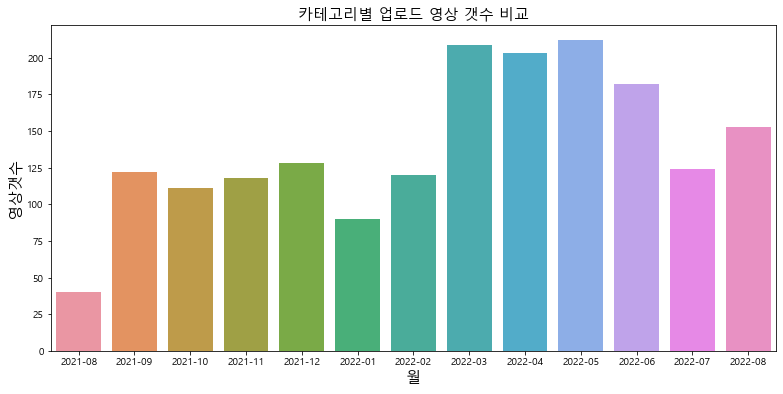

In [28]:
# 그의 결과에 따른 시각화
plt.figure(figsize=(13,6))
ax = sns.countplot(x="월",hue='Dominant_Topic', data=topic1)
plt.xlabel("월", fontsize = 15)
plt.ylabel("영상갯수", fontsize = 15)
plt.title("카테고리별 업로드 영상 갯수 비교", size = 15)

## 카테고리별 요일간 조회수 평균 비교

In [16]:
#업로드일을 활용하여 각 영상 업로드날의 요일을 확인

topic2 = topic[['제목','동영상_ID','업로드일','ttt','Text','Dominant_Topic','조회수','좋아요','주당조회수']]
topic2['요일'] = topic2['업로드일'].dt.weekday

AxesSubplot(0.125,0.125;0.775x0.755)


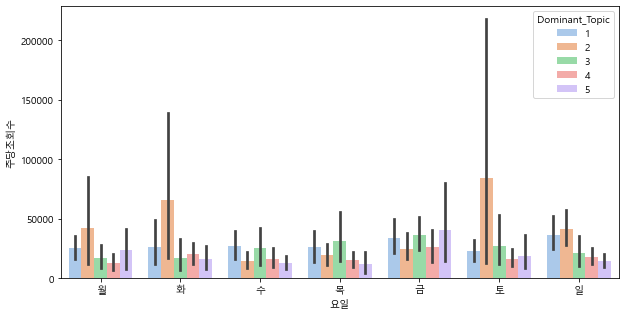

In [17]:
#요일별 카테고리마다 평균 주당 조회수값을 구하여 시각화.
#각각의 주당 조회수값의 총량이 다르기에, 표준화가 필요함.

plt.figure(figsize=(10,5))
ax = sns.barplot(x="요일", y="주당조회수", hue="Dominant_Topic", data=topic2, palette="pastel")
ax.set_xticklabels(["월","화","수","목","금","토","일"])
print(ax)

In [18]:
#표준화를 위해 각 카테고리 주당조회수의 합을 구함
T1 = topic2[topic2['Dominant_Topic'] == 1]
T2 = topic2[topic2['Dominant_Topic'] == 2]
T3 = topic2[topic2['Dominant_Topic'] == 3]
T4 = topic2[topic2['Dominant_Topic'] == 4]
T5 = topic2[topic2['Dominant_Topic'] == 5]

T1T= T1.주당조회수.sum()
T2T= T2.주당조회수.sum()
T3T= T3.주당조회수.sum()
T4T= T4.주당조회수.sum()
T5T= T5.주당조회수.sum()

In [23]:
#각 카테고리의 평균 주당 조회수에 각 카테고리의 주당조회수 총합을 나누어 표준화함
T1['표준조회수'] = T1['주당조회수']/T1T*1000000
T2['표준조회수'] = T2['주당조회수']/T2T*1000000
T3['표준조회수'] = T3['주당조회수']/T3T*1000000
T4['표준조회수'] = T4['주당조회수']/T4T*1000000
T5['표준조회수'] = T5['주당조회수']/T5T*1000000
topicdays = pd.concat([T1,T2,T3,T4,T5])

AxesSubplot(0.125,0.125;0.775x0.755)


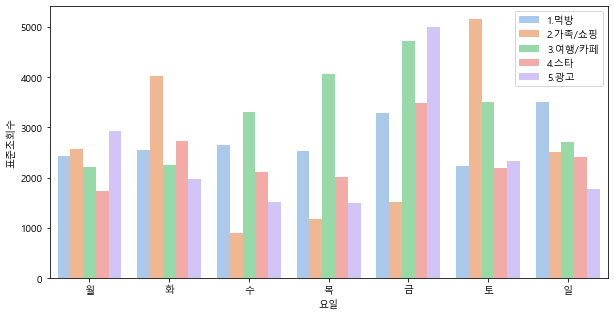

In [30]:
topiclabellist = ['1.먹방','2.가족/쇼핑','3.여행/카페','4.스타','5.광고']
plt.figure(figsize=(10,5))
ax = sns.barplot(x="요일", y="표준조회수", hue="Dominant_Topic", data=topicdays, palette="pastel", ci=None)
ax.set_xticklabels(["월","화","수","목","금","토","일"])
plt.legend(['1.먹방','2.가족/쇼핑','3.여행/카페','4.스타','5.광고'])
print(ax)

In [201]:
# 좋아요에 따른 
topicb = topic1[topic1['좋아요'] != 'ERROR']
topicc = topic2[topicb['좋아요'] != '없음']
topicc['좋아요'] = topicc['좋아요'].str.replace('개','')
topicc['좋아요'] = topicc['좋아요'].astype('int')


In [210]:
topicc['좋아요'].sum()

11294019

In [207]:
likecompare = topicc.groupby('Dominant_Topic').좋아요.mean()

In [208]:
likecompare

Dominant_Topic
1     5645.085443
2    12112.416928
3     5025.084507
4     4834.363636
5     7284.395770
Name: 좋아요, dtype: float64

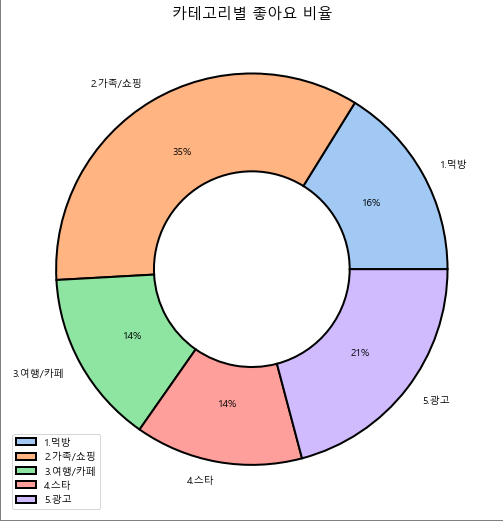

In [209]:
topiclabellist = ['1.먹방','2.가족/쇼핑','3.여행/카페','4.스타','5.광고']
w = {"edgecolor": "black", "linewidth":2, "width":0.5}
colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(9,9), facecolor='white', edgecolor='gray', linewidth=2)
plt.pie(likecompare.values, labels = topiclabellist, colors = colors, autopct='%.0f%%',pctdistance=0.7, wedgeprops=w)
plt.legend(topiclabellist)
plt.title('카테고리별 좋아요 비율', size=15)
plt.show()

## 카테고리별 댓글 수집

"카테고리별댓글크롤링.ipynb"

토픽모델링으로 분류한 카테고리별로 목록을 나누어
유튜브 API를 활용해 댓글을 수집.


In [121]:
#크롤링한 댓글 데이터 불러오기
video1 = pd.read_excel('data/댓글1.xlsx')
video2 = pd.read_excel('data/댓글2.xlsx')
video3 = pd.read_excel('data/댓글3.xlsx')
video4 = pd.read_excel('data/댓글4.xlsx')
video5 = pd.read_excel('data/댓글5.xlsx')

In [122]:
# 카테고리 컬럼 만듬
video1['카테고리'] = 1
video2['카테고리'] = 2
video3['카테고리'] = 3
video4['카테고리'] = 4
video5['카테고리'] = 5

In [123]:
# 2~5 언네임드 제거
video2=video2.drop(columns=['Unnamed: 0'])
video3=video3.drop(columns=['Unnamed: 0'])
video4=video4.drop(columns=['Unnamed: 0'])
video5=video5.drop(columns=['Unnamed: 0'])


In [124]:
# 댓글 콘켓
videos = pd.concat([video1, video2, video3, video4, video5])

In [125]:
# 불필요 컬럼 삭제
videos = videos.drop(columns=['Channel'])

In [126]:
#전처리 전버전 엑셀로 저장
videos.to_excel('data/전처리전버전.xlsx',index=False)

In [127]:
#videos 컬럼 명 변경
videos.columns = ['댓글','닉네임','날짜','좋아요수','비디오이름','카테고리']

In [128]:
# 좋아요수 컬럼 드랍
videos.drop(columns='좋아요수',inplace=True)

In [129]:
# 전처리
def CleanText(readData, Num=True, Eng=True):
# 멘션(@) 제거
    text = re.sub('@[\w_]+', '',readData)

# 대괄호 제거 
    text=re.sub('\[.*\]','',text)
#Remove parentices
    text=re.sub('\(.*\)','',text)

# URL 제거 또는 교체
    text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", ' ', text) # http로 시작되는 url
    text = re.sub(r"[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{2,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)", ' ', text) # http로 시작되지 않는 url

# 해시태그 지움
 #   text = re.sub('[#]+[0-9a-zA-Z_]+', ' ', text)

# &+단어 제거 (ex. &lt, &gt, etc)
    text = re.sub('[&]+[a-z]+', ' ', text)

# 특수문자제거
    text = re.sub('[^0-9a-zA-Zㄱ-ㅎ가-힣]', ' ', text)

# 행제거
    text = text.replace('\n',' ')

    if Num is True:
# 숫자제거
        text = re.sub(r'\d+',' ',text)

    if Eng is True:
        
# 영어제거
        text = re.sub('[a-zA-Z]' , ' ', text)


# 다중공백제거
    text = ' '.join(text.split())
    
    if len(text)<3:
        return np.nan
    else:
        return text

    if len>=512:
        return text
    else:
        return np.nan
    return text


In [130]:
# 한글 전처리한 결과를 댓글 결측지란 컬럼을 생성하여 지정
videos['댓글결측지']=[CleanText(str(i)) for i in videos['댓글']]

In [131]:
# 결측지 확인
videos.isnull().sum()

댓글            8
닉네임         290
날짜          185
비디오이름       185
카테고리          0
댓글결측지    227616
dtype: int64

In [132]:
#결측지 제거
videos = videos.dropna()

In [ ]:
#명사 추출
명사=[]
for text1 in videos['댓글결측지']:
    try:
        명사.append(komoran.get_nouns(text1))
    except:
        명사.append('NULL')

In [ ]:
#리스트 명사를 명사에 컬럼추가
videos['명사']=명사

In [ ]:
#언네임 드랍
videos=videos.drop(columns='Unnamed: 0')

In [ ]:
#명사추출한 결과를 엑셀로 저장
videos.to_excel('명사나눔.xlsx',index=False)

## 카테고리별 키워드 클라우드

In [133]:
#명사나눈 엑셀 파일 불러오기
videos1 = pd.read_excel('data/명사나눔.xlsx')

In [134]:
#결측지 확인
videos1.isnull().sum()

댓글         0
닉네임        0
날짜         0
비디오이름      0
카테고리       0
댓글결측지      0
명사       130
dtype: int64

In [135]:
# 결측지 제거
videos1=videos1.dropna()

In [136]:
# 1 ~ 5 카테고리별로 지정
카테고리1=videos1[videos1['카테고리']==1]
카테고리2=videos1[videos1['카테고리']==2]
카테고리3=videos1[videos1['카테고리']==3]
카테고리4=videos1[videos1['카테고리']==4]
카테고리5=videos1[videos1['카테고리']==5]

In [137]:
## str -> 리스트로 바꾸는 법 
list1 = []
for i in 카테고리1['명사']:
    list1.append(ast.literal_eval(i))
    
list2 = []
for i in 카테고리2['명사']:
    list2.append(ast.literal_eval(i))
    
list3 = []
for i in 카테고리3['명사']:
    list3.append(ast.literal_eval(i))
    
list4 = []
for i in 카테고리4['명사']:
    list4.append(ast.literal_eval(i))
    
list5 = []
for i in 카테고리5['명사']:
    list5.append(ast.literal_eval(i))

In [138]:
## 명사 컬럼에 재저장
카테고리1['명사']=list1
카테고리2['명사']=list2
카테고리3['명사']=list3
카테고리4['명사']=list4
카테고리5['명사']=list5

In [139]:
##의미없는 명사 단어 삭제
with open('data/korean_stop_word_4_1.txt', 'r', encoding='utf8') as f:  
    lines= f.readlines()
res_1 = [line.strip() for line in lines]

with open('data/korean_stop_word_4_2.txt', 'r', encoding='utf8') as f:  
    lines= f.readlines()
res_2 = [line.strip() for line in lines]

with open('data/korean_stop_word_4_3.txt', 'r', encoding='utf8') as f:  
    lines= f.readlines()
res_3 = [line.strip() for line in lines]

with open('data/korean_stop_word_4_4.txt', 'r', encoding='utf8') as f:  
    lines= f.readlines()
res_4 = [line.strip() for line in lines]

with open('data/korean_stop_word_4_5.txt', 'r', encoding='utf8') as f:  
    lines= f.readlines()
res_5 = [line.strip() for line in lines]



### stopword 적용

In [140]:
#카테고리 1 
stop_words_1=set(res_1)

outer_1=[]
for i in 카테고리1['명사']:
    inner_1=[]
    for j in i:
        if j not in stop_words_1:
            inner_1.append(j)
    outer_1.append(inner_1)
    
#카테고리2
stop_words_2=set(res_2)

outer_2=[]
for i_2 in 카테고리2['명사']:
    inner_2=[]
    for j_2 in i_2:
        if j_2 not in stop_words_2:
            inner_2.append(j_2)
    outer_2.append(inner_2)
    
#카테고리3
stop_words_3=set(res_3)

outer_3=[]
for i_3 in 카테고리3['명사']:
    inner_3=[]
    for j_3 in i_3:
        if j_3 not in stop_words_3:
            inner_3.append(j_3)
    outer_3.append(inner_3)
    
#카테고리4
stop_words_4=set(res_4)

outer_4=[]
for i_4 in 카테고리4['명사']:
    inner_4=[]
    for j_4 in i_4:
        if j_4 not in stop_words_4:
            inner_4.append(j_4)
    outer_4.append(inner_4)
    
#카테고리5
stop_words_5=set(res_5)

outer_5=[]
for i_5 in 카테고리5['명사']:
    inner_5=[]
    for j_5 in i_5:
        if j_5 not in stop_words_5:
            inner_5.append(j_5)
    outer_5.append(inner_5)

In [141]:
### 카테고리 별 명사 개수

def flatten(l):
    flattenlist = []
    for elem in l:
        if type(elem) ==list:
            for e in elem:
                flattenlist.append(e)
        else:
            flattenlist.append(elem)
    return flattenlist

In [142]:
#카테고리별 단어 카운팅 및 한글자 제외
카테고리1_명사=flatten(outer_1)
카테고리1_명사개수=pd.Series([x for x in 카테고리1_명사 if len(x) > 1])

카테고리2_명사=flatten(outer_2)
카테고리2_명사개수=pd.Series([x for x in 카테고리2_명사 if len(x) > 1])

카테고리3_명사=flatten(outer_3)
카테고리3_명사개수=pd.Series([x for x in 카테고리3_명사 if len(x) > 1])

카테고리4_명사=flatten(outer_4)
카테고리4_명사개수=pd.Series([x for x in 카테고리4_명사 if len(x) > 1])

카테고리5_명사=flatten(outer_5)
카테고리5_명사개수=pd.Series([x for x in 카테고리5_명사 if len(x) > 1])

### 텍스트마이닝

In [143]:
카테고리1_텍스트마이닝=카테고리1_명사개수.value_counts()
df__ = pd.DataFrame({'word':카테고리1_텍스트마이닝.index, 'count':카테고리1_텍스트마이닝.values})
#mask image 
mask_image = imageio.imread('data/talk.png')

wordcloud=WordCloud(font_path, width=800, height=600,
                    mask=mask_image,colormap='magma',
                    background_color="white", max_words=200) #max_words의 defualt는 200 글자 #사진에 출력되는 글자 수

# 단어와 frequency로 dict를 만듦

wordcloud = wordcloud.generate_from_frequencies(dict(카테고리1_텍스트마이닝))

#numpy array로 변환

array=wordcloud.to_array()

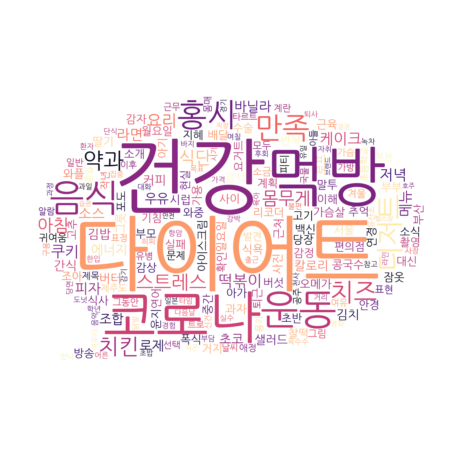

In [144]:
# 화면 출력

fig=plt.figure(figsize=(10,8))
plt.imshow(array, interpolation='bilinear')
plt.axis('off')
plt.show()

In [145]:
###2

카테고리2_텍스트마이닝=카테고리2_명사개수.value_counts()
df__2= pd.DataFrame({'word':카테고리2_텍스트마이닝.index, 'count':카테고리2_텍스트마이닝.values})

#mask image 
mask_image = imageio.imread('data/talk.png')

wordcloud=WordCloud(font_path, width=800, height=600,
                    mask=mask_image,colormap='magma',
                    background_color="white", max_words=200) #max_words의 defualt는 200 글자 #사진에 출력되는 글자 수

# 단어와 frequency로 dict를 만듦

wordcloud2 = wordcloud.generate_from_frequencies(dict(카테고리2_텍스트마이닝))

#numpy array로 변환

array2=wordcloud2.to_array()

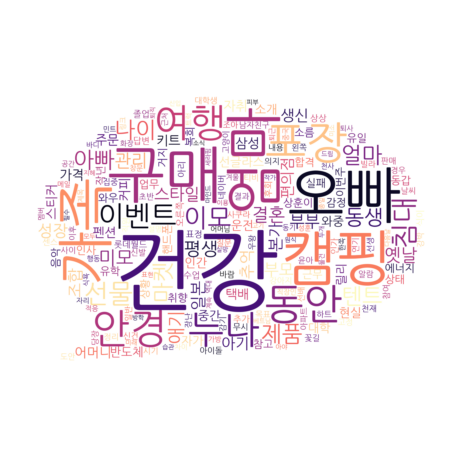

In [146]:
# 화면 출력

fig=plt.figure(figsize=(10,8))
plt.imshow(array2, interpolation='bilinear')
plt.axis('off')
plt.show()

In [147]:
### 3 

카테고리3_텍스트마이닝=카테고리3_명사개수.value_counts()
df__3 = pd.DataFrame({'word':카테고리3_텍스트마이닝.index, 'count':카테고리3_텍스트마이닝.values})

#mask image 
mask_image = imageio.imread('data/talk.png')

wordcloud=WordCloud(font_path, width=800, height=600,
                    mask=mask_image,colormap='magma',
                    background_color="white", max_words=200) #max_words의 defualt는 200 글자 #사진에 출력되는 글자 수

# 단어와 frequency로 dict를 만듦

wordcloud3 = wordcloud.generate_from_frequencies(dict(카테고리3_텍스트마이닝))

#numpy array로 변환

array3=wordcloud3.to_array()

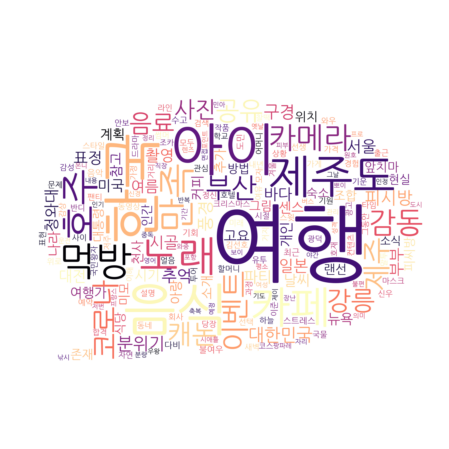

In [148]:
# 화면 출력

fig=plt.figure(figsize=(10,8))
plt.imshow(array3, interpolation='bilinear')
plt.axis('off')
plt.show()

In [149]:
### 4 

카테고리4_텍스트마이닝=카테고리4_명사개수.value_counts()
df__4 = pd.DataFrame({'word':카테고리4_텍스트마이닝.index, 'count':카테고리4_텍스트마이닝.values})

#mask image 
mask_image = imageio.imread('data/talk.png')

wordcloud=WordCloud(font_path, width=800, height=600,
                    mask=mask_image,colormap='viridis',
                    background_color="white", max_words=200) #max_words의 defualt는 200 글자 #사진에 출력되는 글자 수

# 단어와 frequency로 dict를 만듦

wordcloud4= wordcloud.generate_from_frequencies(dict(카테고리4_텍스트마이닝))

#numpy array로 변환

array4=wordcloud4.to_array()

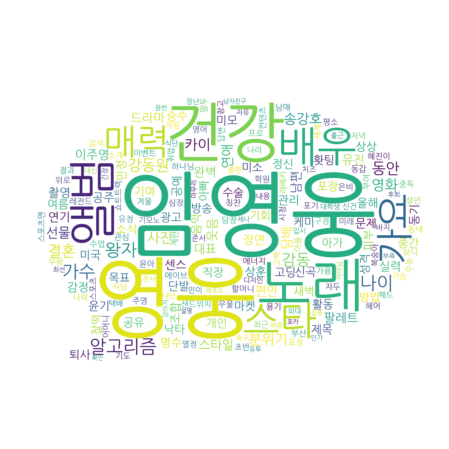

In [150]:
# 화면 출력

fig=plt.figure(figsize=(10,8))
plt.imshow(array4, interpolation='bilinear')
plt.axis('off')
plt.show()

In [151]:
#### 5

카테고리5_텍스트마이닝=카테고리5_명사개수.value_counts()
df__5 = pd.DataFrame({'word':카테고리5_텍스트마이닝.index, 'count':카테고리5_텍스트마이닝.values})


#mask image 
mask_image = imageio.imread('data/talk.png')

wordcloud=WordCloud(font_path, width=800, height=600,
                    mask=mask_image,colormap='magma',
                    background_color="white", max_words=200) #max_words의 defualt는 200 글자 #사진에 출력되는 글자 수

# 단어와 frequency로 dict를 만듦

wordcloud5= wordcloud.generate_from_frequencies(dict(카테고리5_텍스트마이닝))

#numpy array로 변환

array5=wordcloud5.to_array()

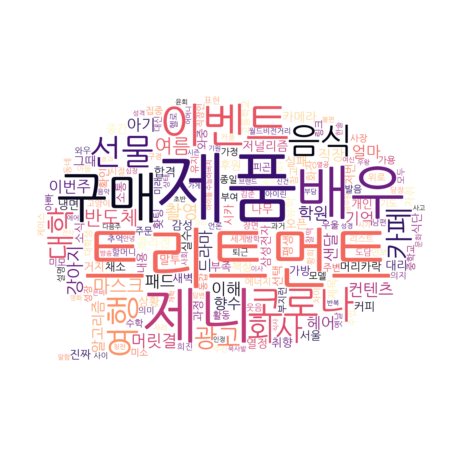

In [152]:
# 화면 출력

fig=plt.figure(figsize=(10,8))
plt.imshow(array5, interpolation='bilinear')
plt.axis('off')
plt.show()

## 카테고리별 키워드 빈도 분석

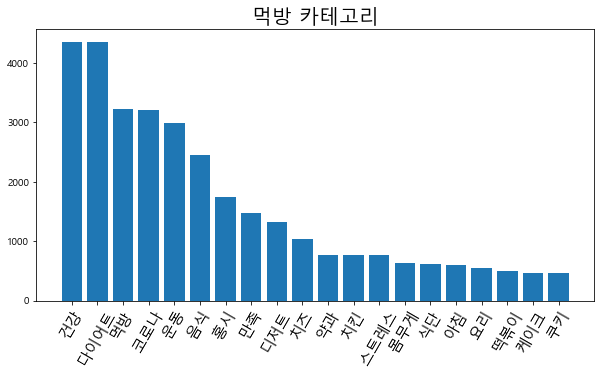

In [153]:
#먹방 카테고리 키워드 시각화
top20_1=df__.head(20)
plt.figure(figsize=(10,5))
plt.bar(top20_1['word'],top20_1['count'])
plt.xticks(rotation=60,fontsize=15)
plt.title('먹방 카테고리',fontsize=20)
plt.show()

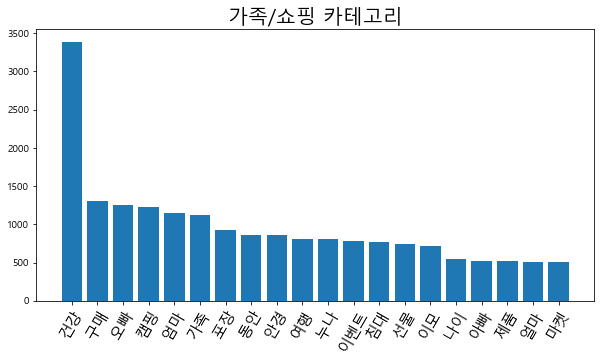

In [154]:
#가족/쇼핑 카테고리 키워드 시각화
top20_2=df__2.head(20)
plt.figure(figsize=(10,5))
plt.bar(top20_2['word'],top20_2['count'])
plt.xticks(rotation=60,fontsize=15)
plt.title('가족/쇼핑 카테고리',fontsize=20)
plt.show()

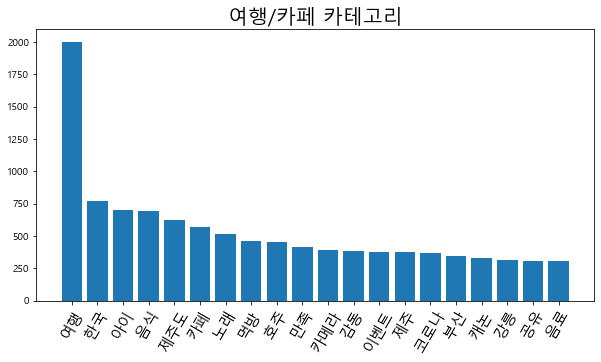

In [155]:
#여행/카페 카테고리 키워드 시각화
top20_3=df__3.head(20)
plt.figure(figsize=(10,5))
plt.bar(top20_3['word'],top20_3['count'])
plt.xticks(rotation=60,fontsize=15)
plt.title('여행/카페 카테고리',fontsize=20)
plt.show()

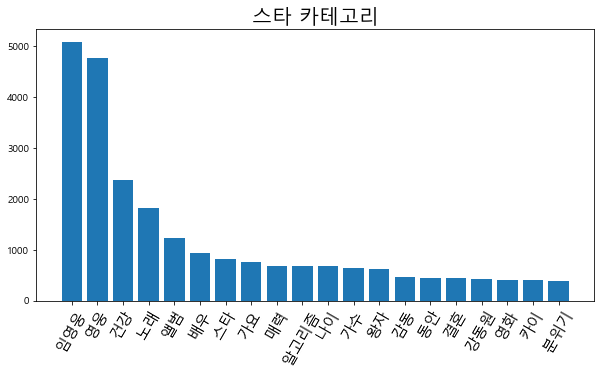

In [156]:
#스타 카테고리 키워드 시각화
top20_4=df__4.head(20)
plt.figure(figsize=(10,5))
plt.bar(top20_4['word'],top20_4['count'])
plt.xticks(rotation=60,fontsize=15)
plt.title('스타 카테고리',fontsize=20)
plt.show()

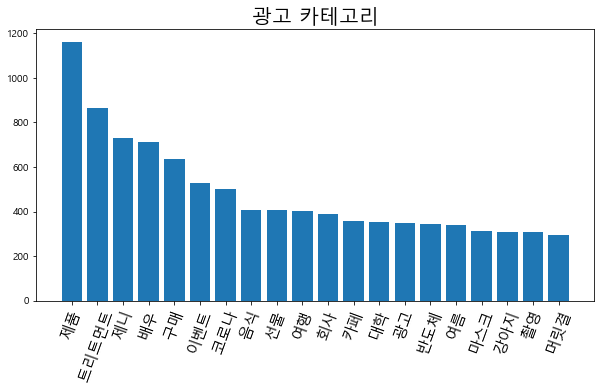

In [157]:
#광고 카테고리 키워드 시각화
top20_5=df__5.head(20)
plt.figure(figsize=(10,5))
plt.bar(top20_5['word'],top20_5['count'])
plt.xticks(rotation=70,fontsize=15)
plt.title('광고 카테고리',fontsize=20)
plt.show()

### 카테고리별 좋아요Top20 제목키워드 분석

In [179]:
topictop20 = topic1.sort_values('좋아요').head(20)

In [191]:
Cat1 = topic3[topic3['Dominant_Topic']==1]
Cat2 = topic3[topic3['Dominant_Topic']==2]
Cat3 = topic3[topic3['Dominant_Topic']==3]
Cat4 = topic3[topic3['Dominant_Topic']==4]
Cat5 = topic3[topic3['Dominant_Topic']==5]

In [211]:
Cat1top = Cat1.sort_values('좋아요', ascending=False).head(20)
Cat2top = Cat2.sort_values('좋아요', ascending=False).head(20)
Cat3top = Cat3.sort_values('좋아요', ascending=False).head(20)
Cat4top = Cat4.sort_values('좋아요', ascending=False).head(20)
Cat5top = Cat5.sort_values('좋아요', ascending=False).head(20)

,업로드일,조회수,ttt,Dominant_Topic,Keywords,기준-업로드일,주,주당조회수,좋아요,월
1207,2022-05-12,2727939,화가 업로드 그림 쏘니 폴라로이드,1,"먹방, 일상, 시작, 화질, 데일리, 코로나, 직장인, 자취, 치즈, 설정",102 days,14,194853.0,98382,2022-05
1100,2022-04-24,2424608,용량 재료 소분 자취 손질 미니 볶음 비빔 당면 아롱사태 수육 이번코스트 소분 요리...,1,"먹방, 일상, 시작, 화질, 데일리, 코로나, 직장인, 자취, 치즈, 설정",120 days,17,142624.0,58731,2022-04
1122,2022-04-28,2165378,분간 휴식 디저트 베이킹,1,"먹방, 일상, 시작, 화질, 데일리, 코로나, 직장인, 자취, 치즈, 설정",116 days,16,135336.0,46165,2022-04
640,2022-02-10,2339439,사랑 약과 국물 닭발 맘모스 허니 콤보 곱창전골 아망 호떡 로프 디저트 간식 공개 ...,1,"먹방, 일상, 시작, 화질, 데일리, 코로나, 직장인, 자취, 치즈, 설정",193 days,27,86646.0,40771,2022-02
1215,2022-05-13,1163647,신명 화가 업로드 그림 쏘니 폴라로이드,1,"먹방, 일상, 시작, 화질, 데일리, 코로나, 직장인, 자취, 치즈, 설정",101 days,14,83118.0,40592,2022-05
1104,2022-04-24,1192783,기상 공부 코스트 연어 파주 프리미엄 아울렛,1,"먹방, 일상, 시작, 화질, 데일리, 코로나, 직장인, 자취, 치즈, 설정",120 days,17,70164.0,33347,2022-04
1222,2022-05-14,976425,전무후무 마지막 업로드 그림 쏘니 폴라로이드 그림 석양,1,"먹방, 일상, 시작, 화질, 데일리, 코로나, 직장인, 자취, 치즈, 설정",100 days,14,69745.0,30022,2022-05
512,2021-12-31,1353233,초등학교 마지막촬영방역 수칙 촬영,1,"먹방, 일상, 시작, 화질, 데일리, 코로나, 직장인, 자취, 치즈, 설정",234 days,33,41007.0,29695,2021-12
526,2022-01-05,1071086,대량 생산 과자 감성 카페 내복 단체 주문 과자 카페 준비 시청 새해 건강 내복,1,"먹방, 일상, 시작, 화질, 데일리, 코로나, 직장인, 자취, 치즈, 설정",229 days,32,33471.0,28728,2022-01
1123,2022-04-28,843011,할리우드 투어 먹방 운동 왓츠 인마 시즌 시즌 먹방 일상 다음 할리우드 미국 일상 ...,1,"먹방, 일상, 시작, 화질, 데일리, 코로나, 직장인, 자취, 치즈, 설정",116 days,16,52688.0,27132,2022-04
